In [1]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import glob
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from tqdm import tqdm

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/valid/images/*.jpg')
test = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')
val_files = np.unique(np.array([x.split('/')[-1][:3] for x in val]))
test_files = np.unique(np.array([x.split('/')[-1][:3] for x in test]))
val_set = list(val_files)+list(test_files)

In [4]:
class Ocelot(Dataset):
    def __init__(self,val=False):
        self.val = val
        temp = glob.glob('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/*.jpg')
        self.tissue_imgs = [x for x in temp if x.split('/')[-1][:3] not in val_set]
        self.val_imgs = [x for x in temp if x.split('/')[-1][:3] in val_set]

        self.masks = ['/workspace/jay/DDP/Ocelot/ocelot2023/annotations/train/tissue/'+x.split('/')[-1][:3]+'.png' for x in self.tissue_imgs]
        self.val_masks = [f'/workspace/jay/DDP/Ocelot/ocelot2023/annotations/train/tissue/'+x.split('/')[-1][:3]+'.png' for x in self.val_imgs]                 
        
    def __len__(self): 
        if self.val:
            return len(self.val_imgs)
        else:
            return len(self.tissue_imgs)

    def __getitem__(self, idx):
        
        if self.val:
            file = self.val_imgs[idx]
            mask = self.val_masks[idx]
        else:
            file = self.tissue_imgs[idx]
            mask = self.masks[idx]
            
        name = file.split('/')[-1].split('.')[0]
        tissue = Image.open(file)
        annot = np.array(Image.open(mask))
        mask = np.zeros((3,annot.shape[0],annot.shape[1]))
        mask[0][np.where(annot==1)] = 1
        mask[1][np.where(annot==2)] = 1
        mask[2][np.where(annot==255)] = 1
        mask = torch.Tensor(mask)
        
        if not self.val:
            if random.uniform(0, 1)>0.5:
                tissue = T.functional.hflip(tissue)
                mask = T.functional.hflip(mask)
            if random.uniform(0, 1)>0.5:
                rot = random.uniform(0,1)
                if rot<0.5 and rot>=0.25:
                    tissue = T.functional.rotate(tissue,angle=90)
                    mask = T.functional.rotate(mask,angle=90)
                elif rot>=0.5 and rot<0.75:
                    tissue = T.functional.rotate(tissue,angle=180)
                    mask = T.functional.rotate(mask,angle=180)
                elif rot>=0.75 and rot<=1:
                    tissue = T.functional.rotate(tissue,angle=270)
                    mask = T.functional.rotate(mask,angle=270)
#             if random.uniform(0, 1)>0.5:
#                 tissue = T.functional.adjust_brightness(tissue, 0.1)
#                 tissue = T.functional.adjust_contrast(tissue,0.1)
#                 tissue = T.functional.adjust_saturation(tissue,0.1)
#                 tissue = T.functional.adjust_hue(tissue,0.1)
                
        tissue = np.array(tissue)
        tissue = tissue / 255
        tissue = tissue - 0.5
        tissue = torch.Tensor(np.moveaxis(tissue, -1, 0))
    
        return tissue,mask,name

In [5]:
device = 'cuda:0'

# model = smp.UnetPlusPlus(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=3,                      # model output channels (number of classes in your dataset)
# )
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_depth=5,
    encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    activation=None,
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [6]:
batch_size = 32
model = model.to(device)
ds = Ocelot(val=False)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=3)
val_ds = Ocelot(val=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

criterion = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)
#criterion = torch.nn.CrossEntropyLoss().to(device)
#criterion = smp.losses.FocalLoss(mode=smp.losses.MULTILABEL_MODE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=5e-5)

softmax = torch.nn.Softmax(dim=1)

In [7]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
for epoch in (range(200)):
    total_loss = 0
    model.train()
    for tissue,mask,_ in (dl):
        optimizer.zero_grad()
        image = tissue.to(device)
        mask = (mask.float()).to(device)
        out = model(image)
        loss = criterion(out, mask)
        total_loss += loss
        loss.backward()
        optimizer.step()
    print(f'{epoch}: Train loss = {total_loss/len(dl):.4f}')
    train_losses.append(total_loss/len(dl))
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for tissue,mask,_ in (val_dl):
            image = tissue.to(device)
            mask = (mask.float()).to(device)
            out = model(image)
            val_loss = criterion(out, mask)
            total_val_loss += val_loss
        print(f'{epoch}: Validation loss = {total_val_loss/len(val_dl):.4f}')
        val_losses.append(total_val_loss/len(val_dl))
        
    lr_scheduler.step()
    if total_val_loss/len(val_dl) < best_val_loss:
        best_val_loss = total_val_loss/len(val_dl)
        print('Best val loss updated, model saved')
        torch.save(model, f'/workspace/jay/DDP/Ocelot/tissue_seg/deeplab_dice_ckpts/{epoch}_{total_val_loss/len(val_dl):.5f}.pt')
    print('------------------------------------------------')

0: Train loss = 0.5563
0: Validation loss = 0.5708
Best val loss updated, model saved
------------------------------------------------
1: Train loss = 0.4742
1: Validation loss = 0.5580
Best val loss updated, model saved
------------------------------------------------
2: Train loss = 0.4471
2: Validation loss = 0.4748
Best val loss updated, model saved
------------------------------------------------
3: Train loss = 0.4331
3: Validation loss = 0.4466
Best val loss updated, model saved
------------------------------------------------
4: Train loss = 0.4230
4: Validation loss = 0.4518
------------------------------------------------
5: Train loss = 0.4004
5: Validation loss = 0.4325
Best val loss updated, model saved
------------------------------------------------
6: Train loss = 0.3952
6: Validation loss = 0.4402
------------------------------------------------
7: Train loss = 0.3821
7: Validation loss = 0.4395
------------------------------------------------
8: Train loss = 0.3695
8:

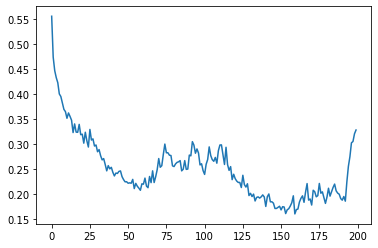

In [8]:
plt.plot([x.detach().cpu() for x in train_losses])

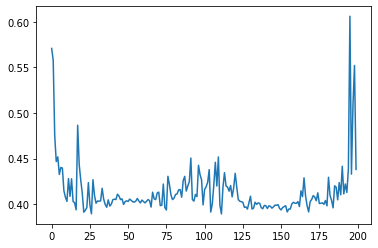

In [9]:
plt.plot([x.detach().cpu() for x in val_losses])